<a href="https://colab.research.google.com/github/GitMechub/Refrigeration-Cycle_Analysis/blob/main/Refrigeration_Cycle_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Refrigeration-Cycle_Analysis - v1.1.0**

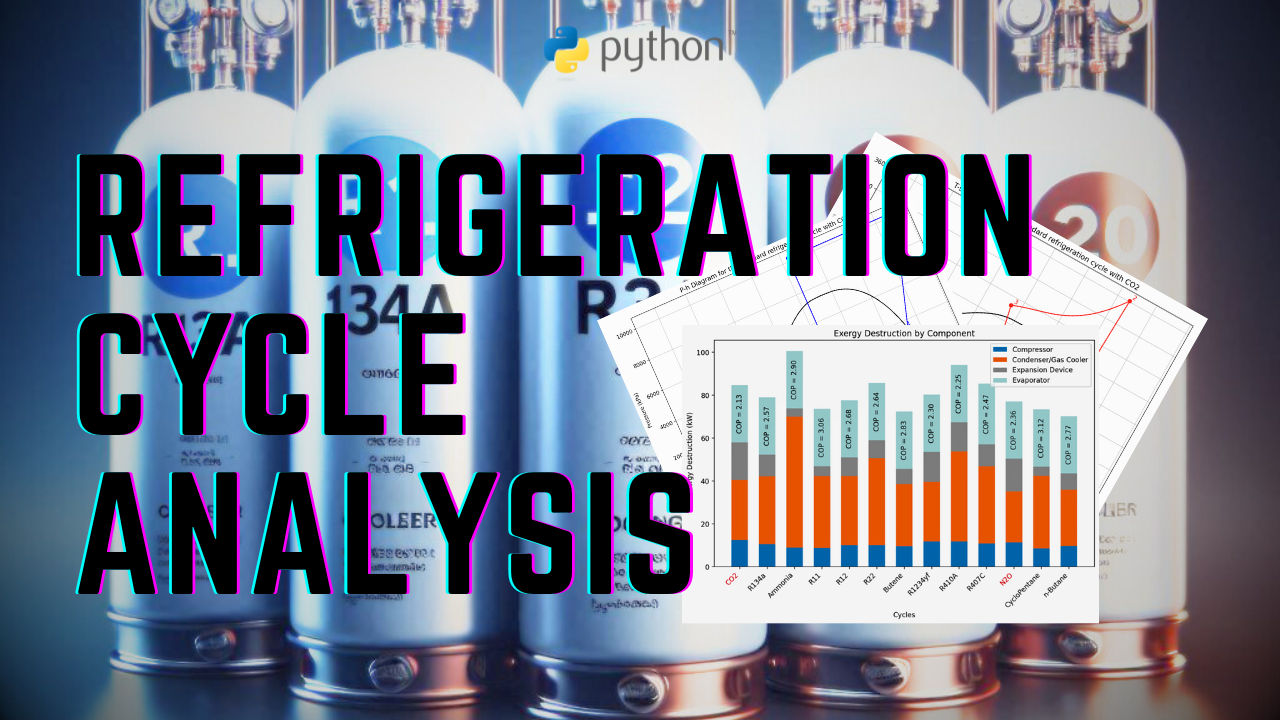

Please, subscribe to the channel [Mechub](https://youtube.com/@Mechub?sub_confirmation=1)
and check my [GitHub](https://github.com/GitMechub)

---

*Por favor, inscreva-se no canal: [Mechub](https://youtube.com/@Mechub?sub_confirmation=1) e visite o meu [GitHub](https://github.com/GitMechub)*

# PACKS

In [ ]:
pip install CoolProp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 44.5 MB/s eta 0:00:00


In [ ]:
from CoolProp import AbstractState
from CoolProp.CoolProp import PhaseSI, PropsSI, get_global_param_string
import CoolProp.CoolProp as CoolProp
from CoolProp.HumidAirProp import HAPropsSI
import CoolProp.Plots as CPP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
def escolher_fluido():
  fluidos_disponiveis = [
    "R134a", "R12", "R22", "R404A", "R407C", "R410A", "R507A", "Ammonia", "CO2",
    "R1234yf", "R23", "R32", "R11", "R123", "R13", "R1234ze", "R245fa",
    "Ethane", "Isopentane", "Isohexane", "IsoButane", "n-Propane", "n-Butane", "n-Pentane",
    "CycloPropane", "CycloPentane", "Propylene", "Xenon", "SulfurDioxide", "EthylBenzene",
    "Ethanol", "Ethylene", "N2O"
  ]

  while True:
      print("Choose a refrigerant fluid from the list below:")
      for i, fluido in enumerate(fluidos_disponiveis, 1):
          print(f"[{i}] {fluido}")

      # Ask for the fluid choice
      escolha = input("Enter the number corresponding to the desired fluid: ")

      try:
          escolha = int(escolha)
          if 1 <= escolha <= len(fluidos_disponiveis):
              fluido_1 = fluidos_disponiveis[escolha - 1]
              print(f"You chose the fluid: {fluido_1}")
              return fluido_1
          else:
              print("Invalid choice. Please select a valid fluid.")
      except ValueError:
          print("Invalid input. Please enter a number corresponding to a fluid.")

In [ ]:
from IPython.display import display, Math, Latex

def print_equations():
  print('\nExergy Rate:\n')
  display(Math(r'\frac{d\dot{B}}{dt} = \sum_i \left(1 - \frac{T_0}{T_i}\right) \dot{Q}_i - \left[ \dot{W}_{VC} - p_0 \left( \frac{dV_{VC}}{dt} \right) \right] - T_0 \dot{S}_{g} + \sum_e \dot{m}_e b_{fe} - \sum_s \dot{m}_s b_{fs}'))

  print('\nExergy Destruction Rate [kW] - Compressor (1-2):\n')  # Considering heat transfer based on the fluid's input temperature
  display(Math(r'\dot{B}_{d c} = \left(1 - \frac{T_0}{T_{c}}\right) \dot{Q}_{c} + \dot{W}_{c} + \dot{m}[h_1-h_2 - T_0(s_1-s_2) ]'))

  print('\nExergy Destruction Rate [kW] - Gas Cooler / Condenser (2-3):\n')
  display(Math(r'\dot{B}_{d Q} = \left(1 - \frac{T_0}{T_2}\right) \dot{Q}_{Q} + \dot{m}[h_2-h_3 - T_0(s_2-s_3) ]'))

  print('\nExergy Destruction Rate [kW] - Expansion Device (3-4):\n')
  display(Math(r'\dot{B}_{d E} = \dot{m}T_0(s_4-s_3)'))

  print('\nExergy Destruction Rate [kW] - Evaporator (4-1):\n')
  display(Math(r'\dot{B}_{d F} = \left(\frac{T_0}{T_1} - 1\right) \dot{Q}_{F} + \dot{m}[h_4-h_1 - T_0(s_4-s_1) ]'))

  print('\nTotal Exergy Destruction Rate [kW]:\n')
  display(Math(r'\dot{B}_{d total} = \dot{B}_{d c}+\dot{B}_{d Q}+\dot{B}_{d E}+\dot{B}_{d F} '))

  print('\n--\n\nRelative Exergy Destruction Rate:\n')
  display(Math(r'r_B = \frac{\dot{B}_{d}}{\dot{B}_{d total}}'))

  print('\n--\n\nExergy Efficiency:\n')
  display(Math(r'n_B = \frac{\dot{B}_{gain}}{\dot{B}_{cost}} = \frac{\left(\frac{T_0}{T_1} - 1\right) \dot{Q}_{F}}{\dot{W}_c}'))

  print('\n--\n\nEntropic Average Temperature:\n')
  display(Math(r'T_{\text{s,avg}} = \frac{h_2 - h_3}{s_2 - s_3}'))


# INPUT

In [ ]:
########################################## INPUT  #################################################

T_evap = 273.15 + 10  # Evaporation temperature [K]
T_cond = 273.15 + 40  # Condensation temperature or outlet from gas cooler if transcritical [K]
n_is = 0.85  # Isentropic efficiency of the compressor
Q_evap = 120e3  # Heat load [W]
r_Qc = 0.1  # % Fraction of the compressor input power that is lost as heat to the surroundings
T_sup = 0  # Superheating temperature difference [K]
T_sub = 0  # Subcooling temperature difference [K]

# Reference Temperatures
T_H = 273.15 + 30   # High-temperature medium (below T_cond) [K]
T_L = 273.15 + 20   # Low-temperature medium (above T_evap) [K]

# List for comparisons: (among the fluids available in ["R134a", "R12", "R22", "R404A", "R407C", "R410A", "R507A", "Ammonia", "CO2","R1234yf", "R23", "R32", "R11", "R123", "R13", "R1234ze", "R245fa","Ethane", "Isopentane", "Isohexane", "IsoButane", "n-Propane", "n-Butane", "n-Pentane","CycloPropane", "CycloPentane", "Propylene", "Xenon", "SulfurDioxide", "EthylBenzene","Ethanol", "Ethylene", "N2O"])
fluid_list = ['R134a', 'R11', 'R12', 'R22', 'R1234yf', 'R410A', 'R32', 'CO2', 'Ammonia','N2O']

fluido_1 = escolher_fluido()

###################################################################################################

Choose a refrigerant fluid from the list below:
[1] R134a
[2] R12
[3] R22
[4] R404A
[5] R407C
[6] R410A
[7] R507A
[8] Ammonia
[9] CO2
[10] R1234yf
[11] R23
[12] R32
[13] R11
[14] R123
[15] R13
[16] R1234ze
[17] R245fa
[18] Ethane
[19] Isopentane
[20] Isohexane
[21] IsoButane
[22] n-Propane
[23] n-Butane
[24] n-Pentane
[25] CycloPropane
[26] CycloPentane
[27] Propylene
[28] Xenon
[29] SulfurDioxide
[30] EthylBenzene
[31] Ethanol
[32] Ethylene
[33] N2O
Enter the number corresponding to the desired fluid: 9
You chose the fluid: CO2


# CODE

## Refrigeration Cycle

In [ ]:
def ciclo_refrigeracao(T_evap, T_cond, n_is, Q_evap, r_Qc, fluido_1, T_sup=0, T_sub=0, fluido_escolhido=1):

  try:

      # State 1 - Saturated vapor in the evaporator (Q = 1)

      P1 = PropsSI("P", "T", T_evap, "Q", 1, fluido_1)
      T1 = T_evap + T_sup
      try:
        H1 = PropsSI("H", "P", P1, "T", T1, fluido_1)
        S1 = PropsSI("S", "P", P1, "T", T1, fluido_1)
      except:
        T1 = PropsSI("T", "P", P1, "Q", 1, fluido_1)
        H1 = PropsSI("H", "P", P1, "Q", 1, fluido_1)
        S1 = PropsSI("S", "P", P1, "Q", 1, fluido_1)


      # Supercritical cycle?

      T_critica = PropsSI("TCRIT", fluido_1)  # Critical temperature of the fluid
      if T_cond >= T_critica:   # If supercritical
          transc_cycle = True
      else:
          transc_cycle = False


      # States 2 and 3 - Condenser/Gas cooler

      ## Subcritical:

      if transc_cycle is False:
        P_cond = PropsSI("P", "Q", 1, "T", T_cond, fluido_1)    # Condensation pressure
        P2 = P_cond
        S2s = S1  # Isentropic
        H2s = PropsSI("H", "S", S2s, "P", P2, fluido_1)
        H2 = ((H2s - H1) / n_is) + H1
        S2 = PropsSI("S", "P", P2, "H", H2, fluido_1)
        T2 = PropsSI("T", "P", P2, "S", S2, fluido_1)   # Temperature at point 2 (above condensation temperature)

        P3 = P2
        T3 = PropsSI("T", "P", P3, "Q", 0, fluido_1) - T_sub

        try:
          # Subcooled: uses T3
          H3 = PropsSI("H", "P", P3, "T", T3, fluido_1)
          S3 = PropsSI("S", "P", P3, "T", T3, fluido_1)
        except:
          # Saturated: uses Q = 0
          T3 = PropsSI("T", "P", P3, "Q", 0, fluido_1)
          H3 = PropsSI("H", "P", P3, "Q", 0, fluido_1)    # Considering saturated liquid at condenser outlet
          S3 = PropsSI("S", "P", P3, "Q", 0, fluido_1)


      ## Supercritical:

      ### NOTE: T_cond will be calculated later. The entry temperature is the outlet temperature of the gas cooler (ambient):

      else:

        ### Get P2 for better COP:
        P2_min = PropsSI("PCRIT", fluido_1) * 1.05  # Initial pressure (greater than critical)
        P2_max = P2_min * 2  # Upper limit of P2
        P2 = P2_min
        melhor_COP = 0
        P2_list = []
        COP_list = []

        while P2 < P2_max:
          try:

            S2s = S1  # Isentropic
            H2s = PropsSI("H", "S", S2s, "P", P2, fluido_1)
            H2 = ((H2s - H1) / n_is) + H1
            T2 = PropsSI("T", "H", H2, "P", P2, fluido_1)
            S2 = PropsSI("S", "P", P2, "H", H2, fluido_1)

            T3 = T_cond
            P3 = P2  # Gas cooler pressure = P2
            H3 = PropsSI("H", "P", P3, "T", T3, fluido_1)
            S3 = PropsSI("S", "P", P3, "H", H3, fluido_1)

            # Evaporator cooling [J/kg]
            q_evap_spec = H1 - H3

            # Compressor specific work input [J/kg], corrected for shell heat losses
            w_comp_spec = (H2 - H1) / (1 - r_Qc)

            COP = q_evap_spec / w_comp_spec

            P2_list.append(P2 / 1e5)  # Converting to bar
            COP_list.append(COP)

            if COP > melhor_COP:
                melhor_COP = COP
                melhor_P2 = P2

          except:
            pass

          P2 += 1e4  # Pressure increment [Pa]

        if fluido_escolhido == 1:
            #### Plot the COP vs. P2 curve
            plt.figure(figsize=(10, 6))
            plt.plot(P2_list, COP_list, label="COP vs P2", color="blue", linewidth=2)
            plt.axvline(melhor_P2 / 1e5, color="red", linestyle="--", label=f"Optimal P2 = {melhor_P2/1e5:.2f} bar")
            plt.xlabel("P2 (bar)", fontsize=12)
            plt.ylabel("COP", fontsize=12)
            plt.title("COP vs P2 Curve (Supercritical Fluid)", fontsize=14)
            plt.legend()
            plt.grid()
            plt.show()

        ### Results for States 2 and 3:
        P2 = melhor_P2
        S2s = S1  # Isentropic
        H2s = PropsSI("H", "S", S2s, "P", P2, fluido_1)
        H2 = ((H2s - H1) / n_is) + H1
        T2 = PropsSI("T", "H", H2, "P", P2, fluido_1)
        S2 = PropsSI("S", "P", P2, "H", H2, fluido_1)

        T3 = T_cond
        P3 = P2  # Gas cooler pressure = P2
        H3 = PropsSI("H", "P", P3, "T", T3, fluido_1)
        S3 = PropsSI("S", "P", P3, "H", H3, fluido_1)

      # State 4

      H4 = H3
      P4 = P1
      T4 = PropsSI("T", "P", P4, "H", H4, fluido_1)

      ## Entropy at state 4
      try:
        Q4 = PropsSI("Q", "P", P4, "H", H4, fluido_1)
        S4 = PropsSI("S", "P", P4, "Q", Q4, fluido_1)
      except:
        ### Loop to obtain S4 (coolprop error):
        for i in np.arange(0, 1, 0.01):
          H4_vapor_saturado = PropsSI("H", "P", P4, "Q", i, fluido_1)
          if abs(H4 - H4_vapor_saturado)/H4 <= 0.01:
            Q4 = i
        S4 = PropsSI("S", "P", P4, "Q", Q4, fluido_1)


      # Mass flow rate

      m_dot = Q_evap/(H1 - H4)


      # Compressor power (Subcritical)

      W_c = ((H2-H1)*m_dot)/(1-r_Qc) # Compressor power [W]
      Q_c_loss = W_c * r_Qc  # Compressor losses [W]
      Q_cond = Q_evap + W_c - Q_c_loss  # Rejected heat [W]
      COP = Q_evap/W_c


      # Cycle points

      h_vals = [H1, H2, H3, H4, H1]
      s_vals = [S1, S2, S3, S4, S1]
      T_vals = [T1, T2, T3, T4, T1]
      p_vals = [P1, P2, P3, P4, P1]
      labels = ['1', '2', '3', '4', '1']



      if fluido_escolhido == 1:

          # Saturation curve

          T_min = PropsSI('Tmin', fluido_1) + 1
          T_max = PropsSI('Tcrit', fluido_1)
          temperatures = np.linspace(T_min, T_max, 500)
          s_liquid = [PropsSI('S', 'T', T, 'Q', 0, fluido_1) for T in temperatures]
          s_vapor = [PropsSI('S', 'T', T, 'Q', 1, fluido_1) for T in temperatures]
          h_liquid = [PropsSI('H', 'T', T, 'Q', 0, fluido_1) for T in temperatures]
          h_vapor = [PropsSI('H', 'T', T, 'Q', 1, fluido_1) for T in temperatures]
          p_sat = [PropsSI('P', 'T', T, 'Q', 0, fluido_1) / 1000 for T in temperatures]

          plt.figure(figsize=(10, 6))
          plt.plot(np.array(h_liquid) / 1000, p_sat, 'black')
          plt.plot(np.array(h_vapor) / 1000, p_sat, 'black')


          # P-h diagram

          plt.xlabel('Enthalpy (kJ/kg)')
          plt.ylabel('Pressure (kPa)')
          plt.title(f'P-h Diagram for the standard refrigeration cycle with {fluido_1}')
          plt.grid(True)

          ## Isentropic line between points 1 and 2
          if transc_cycle is False:
              press = np.linspace(P1, P2, 500)
              h_isent = []
              for P in press:
                  h_isent = h_isent + [PropsSI("H", "S", S1, "P", P, fluido_1)]

              plt.plot(np.array(h_vals[1:]) / 1000, np.array(p_vals[1:]) / 1000, 'bo-')
              plt.plot(np.array(h_isent) / 1000, press/1000, 'b--')
          else:
              plt.plot(np.array(h_vals) / 1000, np.array(p_vals) / 1000, 'bo-')

          ## Add numerical labels for each point using plt.annotate
          for i, label in enumerate(labels):
              plt.annotate(label,  # Label text
                          (h_vals[i]/1000, p_vals[i]/1000),  # Point position
                          textcoords="offset points",  # Offset coordinates to avoid overlap
                          xytext=(5,5),  # Position offset to adjust text visualization
                          ha='center', fontsize=10, color='blue')  # Alignment and style


          # T-s diagram

          plt.figure(figsize=(10, 6))
          plt.plot(s_liquid, temperatures, 'black')
          plt.plot(s_vapor, temperatures, 'black')
          plt.plot(s_vals[0:2], [T1, T2], 'ro-')
          #plt.plot(s_vals[2:4], [T3, T4], 'ro-')

          ## Isobaric line between points 2 and 3

          P_critica = PropsSI("PCRIT", fluido_1)  # Critical pressure of the fluid

          if transc_cycle is True:   # If supercritical
              temp = np.linspace(T3, T2, 500)
              s_isob = []
              for T in temp:
                  s_isob = s_isob + [PropsSI("S", "T", T, "P", P2, fluido_1)]

          else:   # If subcritical
              T_sat0 = PropsSI("T", "Q", 0, "P", P2, fluido_1)
              T_sat1 = PropsSI("T", "Q", 1, "P", P2, fluido_1)

              temp = np.linspace(T3, T2, 500).astype(int)   # Remove CoolProp bugs
              temp = np.unique(temp)
              s_isob = []
              for T in temp:
                  if T<T_sat0:
                      s_isob = s_isob + [PropsSI("S", "T", T, "P", P2, fluido_1)]
                  elif T>=T_sat0 and T<=T_sat1:
                      titulo = PropsSI("Q", "T", T, "P", P2, fluido_1)
                      s_isob = s_isob + [PropsSI("S", "Q", titulo, "P", P2, fluido_1)]
                  elif T>T_sat1:
                      s_isob = s_isob + [PropsSI("S", "T", T, "P", P2, fluido_1)]

          #s_isob = [PropsSI('S', 'T', T, 'P', P2, fluido_1) for T in temp]

          plt.plot(s_isob, temp, 'red')

          ## Isobaric line between points 4 and 1

          T_sat0 = PropsSI("T", "Q", 0, "P", P1, fluido_1)
          T_sat1 = PropsSI("T", "Q", 1, "P", P1, fluido_1)
          S_sat1 = PropsSI("S", "Q", 1, "P", P1, fluido_1)

          if T1 > T_sat1:   # For the supersaturated portion
              plt.plot(s_vals[2:4], [T3, T4], 'ro-')
              plt.plot([s_vals[3], S_sat1, s_vals[4]], [T4, T_sat1, T1], 'r-', marker='o', markevery=[0, 2])
          else:
              plt.plot(s_vals[2:5], [T3, T4, T1], 'ro-')

          plt.xlabel('Entropy (J/kg·K)')
          plt.ylabel('Temperature (K)')
          plt.title(f'T-s Diagram for the standard refrigeration cycle with {fluido_1}')
          plt.grid(True)

          ## Add labels for each point
          for i, label in enumerate(labels):
              plt.annotate(label,  # Label text
                          (s_vals[i], T_vals[i]),  # Point position
                          textcoords="offset points",  # Offset coordinates to avoid overlap
                          xytext=(5,5),  # Position offset to adjust text visualization
                          ha='center', fontsize=10, color='red')  # Alignment and style


      # * Volumetric cooling capacity [kJ/m³]
      try:
        VCC = ((H1-H4)/1000)*PropsSI("D", "Q", 1, "P", P1, fluido_1)
      except:
        VCC = np.nan

      # * Volumetric compression work [kJ/m³]
      try:
        VCW = ((H2-H1)/1000)*PropsSI("D", "Q", 1, "P", P1, fluido_1)
      except:
        VCW = np.nan

      # Return results

      dict_result = {
          "State": labels[:-1],
          "h [J/kg]": h_vals[:-1],
          "s [J/kg·K]": s_vals[:-1],
          "T [K]": T_vals[:-1],
          "P [Pa]": p_vals[:-1],
          "Mass flow rate [kg/s]": m_dot,
          "Q_f [W]": Q_evap,
          "W_c [W]": W_c,
          "Q_c [W]": Q_c_loss,
          "Q_q [W]": Q_cond,
          'COP': COP,
          'Volumetric Cooling Capacity [kJ/m³]': VCC, #
          'Volumetric Compression Work [kJ/m³]': VCW, #
          'Isentropic Efficiency of Compressor': n_is,
          "Transcritical?": transc_cycle,
          "Fluid": fluido_1
      }

      if transc_cycle is True:    # Isentropic Average Temperature for the Gas Cooler
        dict_result['Gas Cooler Avg. Temperature [K]'] = abs(
            (dict_result['h [J/kg]'][1] - dict_result['h [J/kg]'][2]) /
            (dict_result['s [J/kg·K]'][1] - dict_result['s [J/kg·K]'][2])
        )


      if fluido_escolhido == 1:
          display(pd.DataFrame(dict_result))

      return dict_result


  except:
    return 0

## Performance Analysis

In [ ]:
def calculo_exergia_padrao(dados, T_H, T_L):
    """
    Parameters:
    Dictionary containing input values for the standard refrigeration cycle with the following keys:
        - 'W_c [W]': Compressor power [W]
        - 'Mass flow rate [kg/s]': Mass flow rate of the fluid [kg/s]
        - 'h [J/kg]': List with entalpies at states 1, 2, 3, and 4 [J/kg]
        - 's [J/kg·K]': List with entropies at states 1, 2, 3, and 4 [J/kg·K]
        - 'T [K]': List with temperatures at states 1, 2, 3, and 4 [K]
        - 'Q_q [W]': Heat in the gas cooler [W]
        - 'Q_f [W]': Heat in the evaporator [W]
        - 'Q_c [W]': Heat exchanged in the compressor [W]
        - "Transcritical?": True if transcritical

    Returns:
    dict: Dictionary with exergy destruction rates and exergy efficiency calculated.

    * NOTE: For the compressor surface temperature T_c, the average of the inlet and outlet temperatures of the compressor will be considered
    """
    # Ambient conditions
    P0 = 101325        # Ambient pressure [Pa]
    T0 = T_H    # In refrigeration systems, the reference temperature is typically set to the temperature of the high-temperature medium

    # Exergy Destruction Rate for the Compressor (1-2)

    B_dc = (
        (1 - (T0 / ((dados['T [K]'][0] + dados['T [K]'][1]) / 2))) * dados['Q_c [W]'] + dados['W_c [W]']
        + dados['Mass flow rate [kg/s]'] *
        (dados['h [J/kg]'][0] - dados['h [J/kg]'][1]
         - T0 * (dados['s [J/kg·K]'][0] - dados['s [J/kg·K]'][1]))
    )

    # Exergy Destruction Rate for the Gas Cooler/Condenser (2-3)

    #Tme_Q = dados['T [K]'][1] if dados['Transcritical?'] is False else abs(
    #    (dados['h [J/kg]'][1] - dados['h [J/kg]'][2]) / (dados['s [J/kg·K]'][1] - dados['s [J/kg·K]'][2])
    #)  # Entropic average temperature if transcritical

    B_dQ = (
        (1 - (T0 / T_H)) * dados['Q_q [W]']
        + dados['Mass flow rate [kg/s]'] *
        (dados['h [J/kg]'][1] - dados['h [J/kg]'][2]
         - T0 * (dados['s [J/kg·K]'][1] - dados['s [J/kg·K]'][2]))
    )

    # Exergy Destruction Rate for the Expansion Device (3-4)

    B_dE = (
        dados['Mass flow rate [kg/s]'] * T0 * (dados['s [J/kg·K]'][3] - dados['s [J/kg·K]'][2])
    )

    # Exergy Destruction Rate for the Evaporator (4-1)

    B_dF = (
        ((T0 / T_L) - 1) * dados['Q_f [W]']
        + dados['Mass flow rate [kg/s]'] *
        (dados['h [J/kg]'][3] - dados['h [J/kg]'][0]
         - T0 * (dados['s [J/kg·K]'][3] - dados['s [J/kg·K]'][0]))
    )

    # Total Exergy Destruction Rate
    B_d_total = B_dc + B_dQ + B_dE + B_dF

    B_d = {
        'Compressor': B_dc / 1e3,
        'Gas Cooler': B_dQ / 1e3,
        'Expansion Device': B_dE / 1e3,
        'Evaporator': B_dF / 1e3
    } if dados["Transcritical?"] == True else {
        'Compressor': B_dc / 1e3,
        'Condenser': B_dQ / 1e3,
        'Expansion Device': B_dE / 1e3,
        'Evaporator': B_dF / 1e3
    }

    # Relative Exergy Destruction Rates
    r_B = {
        'Compressor': B_dc / B_d_total,
        'Gas Cooler': B_dQ / B_d_total,
        'Expansion Device': B_dE / B_d_total,
        'Evaporator': B_dF / B_d_total
    } if dados["Transcritical?"] == True else {
        'Compressor': B_dc / B_d_total,
        'Condenser': B_dQ / B_d_total,
        'Expansion Device': B_dE / B_d_total,
        'Evaporator': B_dF / B_d_total
    }

    # Exergy Efficiency
    B_gain_expr = ((T0 / T_L) - 1) * dados['Q_f [W]']
    B_cost_expr = (
        dados['Mass flow rate [kg/s]'] *
        (dados['h [J/kg]'][1] - dados['h [J/kg]'][0])   # Compressor work
    )
    n_B = B_gain_expr / B_cost_expr

    # Final result in a dictionary in kW
    resultados = {
        'B_d [kW]': B_d,
        'B_d_total [kW]': B_d_total / 1e3,
        'r_B': r_B,
        'n_B': n_B,
        'VCC [MJ/m³]': dados['Volumetric Cooling Capacity [kJ/m³]']/1000 if dados['Volumetric Cooling Capacity [kJ/m³]'] is not np.nan else np.nan,
        'VCW [MJ/m³]': dados['Volumetric Compression Work [kJ/m³]']/1000 if dados['Volumetric Compression Work [kJ/m³]'] is not np.nan else np.nan,
        'COP': dados['COP'] if dados['COP'] is not np.nan else np.nan,
        'Compressor Power [kW]': dados['W_c [W]']/1000 if dados['W_c [W]'] is not np.nan else np.nan,
        'Fluid': dados['Fluid']
    }

    #print(dados['COP'], dados['Fluid'])

    return resultados


In [ ]:
def Bd_comparativo(list_dict_exergia, list_dados):
  """
  Function to compare exergy destruction between multiple fluids,
  considering that the condenser name may vary between 'Gas Cooler' and 'Condenser'.

  list_dict_exergia: List of dictionaries containing exergy values for several fluids
  list_dados: List of dictionaries with fluid data (e.g., properties)
  """

  # Extracting the exergy destruction data for all fluids
  states = [dados["Fluid"] for dados in list_dados]
  transcritical = [dados["Transcritical?"] for dados in list_dados]

  # Initializing the lists of exergy destruction by component
  compressor = [dict_exergia['B_d [kW]']['Compressor'] for dict_exergia in list_dict_exergia]

  # Checking if the key name is 'Gas Cooler' or 'Condenser' and adjusting
  condenser = [
      dict_exergia['B_d [kW]'].get('Condenser', dict_exergia['B_d [kW]'].get('Gas Cooler', 0))
      for dict_exergia in list_dict_exergia
  ]

  expansion = [dict_exergia['B_d [kW]']['Expansion Device'] for dict_exergia in list_dict_exergia]
  evaporator = [dict_exergia['B_d [kW]']['Evaporator'] for dict_exergia in list_dict_exergia]

  # Setting up the chart
  x = np.arange(len(states))  # Positions for the bars
  width = 0.6  # Width of the bars

  # Creating the stacked chart
  compressor_bars = plt.bar(x, compressor, width=width, label='Compressor', color='#1984c5')
  condenser_bars = plt.bar(x, condenser, width=width, bottom=compressor, label='Condenser/Gas Cooler', color='#FF7F50')
  expansion_bars = plt.bar(x, expansion, width=width, bottom=np.array(compressor) + np.array(condenser), label='Expansion Device', color='#9B9B9B')
  evaporator_bars = plt.bar(x, evaporator, width=width, bottom=np.array(compressor) + np.array(condenser) + np.array(expansion), label='Evaporator', color='#badbdb')


  # Adding the COP value inside the bars
  for i, (comp_bar, cond_bar, exp_bar, evap_bar, dados) in enumerate(zip(compressor_bars, condenser_bars, expansion_bars, evaporator_bars, list_dados)):
    # Calculating the positions for the values inside the bars
    y_pos = comp_bar.get_height() + cond_bar.get_height() + exp_bar.get_height() + evap_bar.get_height() / 2
    # Adding the text (COP) on the bar, rotated vertically
    plt.text(comp_bar.get_x() + comp_bar.get_width() / 2, y_pos, f'COP = {dados["COP"]:.2f}', ha='center', va='center', rotation=90, fontsize=10)


  # Setting custom labels
  plt.xticks(x, states, rotation=45, ha='right')  # Initial tilt
  labels = plt.gca().get_xticklabels()  # Getting the X-axis labels

  # Adjusting colors locally based on a condition
  for i, (state, transcritical_) in enumerate(zip(states, transcritical)):
      if transcritical_:  # Condition for a different color (True)
          labels[i].set_color('red')  # Red
      else:
          labels[i].set_color('black')  # Default black

  plt.ylabel('Exergy Destruction (kW)')
  plt.xlabel('Cycles')
  plt.title('Exergy Destruction by Component')
  plt.legend()

  # Show the chart
  plt.show()


In [ ]:
def Bd_comparativo_fig(list_dict_exergia, list_dados):
    """
    Function to compare exergy destruction between multiple fluids,
    considering that the condenser name may vary between 'Gas Cooler' and 'Condenser'.
    """
    # Verificando os dados recebidos
    print("list_dict_exergia:", list_dict_exergia)
    print("list_dados:", list_dados)

    # Extracting the exergy destruction data for all fluids
    states = [dados["Fluid"] for dados in list_dados]
    transcritical = [dados["Transcritical?"] for dados in list_dados]

    # Initializing the lists of exergy destruction by component
    compressor = [dict_exergia['B_d [kW]']['Compressor'] for dict_exergia in list_dict_exergia]
    condenser = [
        dict_exergia['B_d [kW]'].get('Condenser', dict_exergia['B_d [kW]'].get('Gas Cooler', 0))
        for dict_exergia in list_dict_exergia
    ]
    expansion = [dict_exergia['B_d [kW]']['Expansion Device'] for dict_exergia in list_dict_exergia]
    evaporator = [dict_exergia['B_d [kW]']['Evaporator'] for dict_exergia in list_dict_exergia]

    # Imprimir os valores de destruição de exergia para depuração
    print("Compressor:", compressor)
    print("Condenser:", condenser)
    print("Expansion:", expansion)
    print("Evaporator:", evaporator)

    # Setting up the chart
    x = np.arange(len(states))  # Positions for the bars
    width = 0.6  # Width of the bars

    # Verificar as dimensões das variáveis
    if len(states) == 0 or len(compressor) == 0:
        print("Erro: Dados não encontrados ou estão vazios.")
        return

    # Criando o gráfico
    fig, ax = plt.subplots(figsize=(16, 10))  # Novo tamanho da figura

    # Creating the stacked chart
    compressor_bars = ax.bar(x, compressor, width=width, label='Compressor', color='#1984c5')
    condenser_bars = ax.bar(x, condenser, width=width, bottom=compressor, label='Condenser/Gas Cooler', color='#FF7F50')
    expansion_bars = ax.bar(x, expansion, width=width, bottom=np.array(compressor) + np.array(condenser), label='Expansion Device', color='#9B9B9B')
    evaporator_bars = ax.bar(x, evaporator, width=width, bottom=np.array(compressor) + np.array(condenser) + np.array(expansion), label='Evaporator', color='#badbdb')

    # Adding the COP value inside the bars
    for i, (comp_bar, cond_bar, exp_bar, evap_bar, dados) in enumerate(zip(compressor_bars, condenser_bars, expansion_bars, evaporator_bars, list_dados)):
        y_pos = comp_bar.get_height() + cond_bar.get_height() + exp_bar.get_height() + evap_bar.get_height() / 2
        ax.text(comp_bar.get_x() + comp_bar.get_width() / 2, y_pos, f'COP = {dados["COP"]:.2f}', ha='center', va='center', rotation=90, fontsize=10)

    # Set custom labels
    ax.set_xticks(x)
    ax.set_xticklabels(states, rotation=45, ha='right')

    # Adjusting colors locally based on a condition
    for i, (state, transcritical_) in enumerate(zip(states, transcritical)):
        if transcritical_:
            ax.get_xticklabels()[i].set_color('red')
        else:
            ax.get_xticklabels()[i].set_color('black')

    ax.set_ylabel('Exergy Destruction (kW)')
    ax.set_xlabel('Cycles')
    ax.set_title('Exergy Destruction by Component')
    ax.legend()

    # Show the chart
    plt.show()


In [ ]:
def processar_ciclos_refrigeracao(T_evap, T_cond, T_L, T_H, n_is, Q_evap, r_Qc, fluido_1, fluid_list, T_sup=0, T_sub=0):
    """
    Processes refrigeration cycles for the chosen fluid and a list of other fluids.

    Parameters:
        - T_evap: Evaporation temperature
        - T_cond: Condensation temperature (Gas cooler outlet temperature for transcritical cycles)
        - n_is: Isentropic efficiency
        - Q_evap: Evaporation thermal load
        - r_Qc: Thermal transfer ratio
        - fluido_1: Chosen initial fluid
        - lista_de_fluidos: List of additional fluids for simulation

    Returns:
        - list_dados: List of results for each fluid's cycle
        - list_dict_exergia: List of exergy calculations for each fluid
    """

    # Basic input validation
    if not isinstance(T_evap, (int, float)) or not isinstance(T_cond, (int, float)):
        return "Error: T_evap and T_cond must be numbers.", 0
    if not isinstance(n_is, (int, float)) or not (0 <= n_is <= 1):
        return "Error: n_is must be a number between 0 and 1.", 0
    if not isinstance(Q_evap, (int, float)) or Q_evap <= 0:
        return "Error: Q_evap must be a positive number.", 0
    if not isinstance(r_Qc, (int, float)) or r_Qc < 0:
        return "Error: r_Qc must be a positive number.", 0
    if not isinstance(fluido_1, str):
        return "Error: fluido_1 must be a string.", 0

    # List of alternative fluids
    #fluid_list = ['R134a', 'Ammonia', 'R11', 'R12', 'R22', 'Butene', 'R1234yf', 'Methane', 'R410A', 'R407C','CO2', 'N2O', "CycloPentane", "n-Butane"]

    # Remove the chosen initial fluid from the list
    if fluido_1 in fluid_list:
        fluid_list.remove(fluido_1)

    try:
        # Calculate the cycle for the chosen fluid
        result_fluido_escolhido = ciclo_refrigeracao(
            T_evap, T_cond, n_is, Q_evap, r_Qc, fluido_1=fluido_1, T_sup=T_sup, T_sub=T_sub, fluido_escolhido=1
        )

        # Check if the result for the chosen fluid is valid
        if result_fluido_escolhido == 0 or result_fluido_escolhido is None:
            fluid_list.remove(fluido_1)
            return f"Error: Failed to process the chosen fluid '{fluido_1}'.", 0

        # Initialize lists for data and exergies
        list_dict_exergia = [calculo_exergia_padrao(result_fluido_escolhido, T_H, T_L)]
        list_dados = [result_fluido_escolhido]

        # Calculate the average condensation temperature (Tc_)
        Tc_ = abs(
            (result_fluido_escolhido['h [J/kg]'][1] - result_fluido_escolhido['h [J/kg]'][2]) /
            (result_fluido_escolhido['s [J/kg·K]'][1] - result_fluido_escolhido['s [J/kg·K]'][2])
        )

        fluidos_remover = []
        # Process cycles for alternative fluids
        for fluido in fluid_list:
            try:

                T_critica = PropsSI("TCRIT", fluido)  # Critical temperature of the fluid

                if T_cond >= T_critica:   # If supercritical
                    dados_ = ciclo_refrigeracao(
                    T_evap, T_cond, n_is, Q_evap, r_Qc, fluido_1=fluido, T_sup=T_sup, T_sub=T_sub, fluido_escolhido=0
                    )

                else:
                    dados_ = ciclo_refrigeracao(
                    T_evap, Tc_, n_is, Q_evap, r_Qc, fluido_1=fluido, T_sup=T_sup, T_sub=T_sub, fluido_escolhido=0
                    )

                # Add results to the lists
                list_dados.append(dados_)
                list_dict_exergia.append(calculo_exergia_padrao(dados_, T_H, T_L))

            except Exception as e:
                print(f"Error processing fluid {fluido}: {e}")
                fluidos_remover.append(fluido)
                continue


        # Process the data for the exergy table
        fluid_list = [f for f in fluid_list if f not in fluidos_remover]
        fluidos = [fluido_1] + fluid_list

        tabela = []
        print("\n\n * Exergy Destruction Data and Exergy Efficiency:\n")
        for i, item in enumerate(list_dict_exergia):

            if fluidos[i] in fluidos_remover:
                continue

            linha = {
                'Fluid': fluidos[i],
                'Exergy Loss Compressor [kW]': item['B_d [kW]'].get('Compressor', None),
                'Exergy Loss Condenser/Gas Cooler [kW]': item['B_d [kW]'].get('Condenser', item['B_d [kW]'].get('Gas Cooler', None)),
                'Exergy Loss Expansion Device [kW]': item['B_d [kW]'].get('Expansion Device', None),
                'Exergy Loss Evaporator [kW]': item['B_d [kW]'].get('Evaporator', None),
                'Total Exergy Loss [kW]': item['B_d_total [kW]'],
                'Relative Exergy Loss Compressor': item['r_B'].get('Compressor', None),
                'Relative Exergy Loss Condenser/Gas Cooler': item['r_B'].get('Condenser', item['r_B'].get('Gas Cooler', None)),
                'Relative Exergy Loss Expansion Device': item['r_B'].get('Expansion Device', None),
                'Relative Exergy Loss Evaporator': item['r_B'].get('Evaporator', None),
                'Exergy Efficiency': item['n_B'],
                'Volumetric Cooling Capacity [MJ/m³]': item['VCC [MJ/m³]'] if 'VCC [MJ/m³]' in item else np.nan,
                'Volumetric Compression Work [MJ/m³]': item['VCW [MJ/m³]'] if 'VCW [MJ/m³]' in item else np.nan,
                'COP': item['COP'] if 'COP' in item else np.nan,
                'Compressor Power [kW]': item['Compressor Power [kW]'] if 'Compressor Power [kW]' in item else np.nan
            }
            tabela.append(linha)

        # Create the DataFrame
        df_list_dict_exergia = pd.DataFrame(tabela)

        # Display the table
        display(df_list_dict_exergia.head(1))

        list_dados = [x for x in list_dados if x != 0]

        return list_dados, list_dict_exergia, df_list_dict_exergia

    except KeyError as ke:
        return f"Key error accessing data for fluid '{fluido_1}': {ke}", 0
    except ZeroDivisionError as zde:
        return f"Zero division error calculating Tc_: {zde}", 0
    except Exception as e:
        return f"Unexpected error processing cycles: {e}", 0


## Environmental Effects

In [ ]:
def environmental_effects(fluido_1, fluid_list):
  # List of alternative fluids
  #fluid_list = ['R134a', 'Ammonia', 'R11', 'R12', 'R22', 'Butene', 'R1234yf', 'Methane', 'R410A', 'R407C', 'CO2', 'N2O', "CycloPentane", "n-Butane"]

  # Remove the chosen initial fluid from the list
  if fluido_1 in fluid_list:
      fluid_list.remove(fluido_1)

  refrigerants = fluid_list + [fluido_1]

  gwp20 = []
  gwp100 = []
  gwp500 = []

  # Retrieve GWP values for each refrigerant
  for refrigerant in refrigerants[:]:
      try:
          gwp20_value = PropsSI('GWP20', refrigerant)
          gwp100_value = PropsSI('GWP100', refrigerant)
          gwp500_value = PropsSI('GWP500', refrigerant)

          gwp20.append(gwp20_value)
          gwp100.append(gwp100_value)
          gwp500.append(gwp500_value)

      except Exception as e:
          refrigerants.remove(refrigerant)  # Remove invalid refrigerants
          print(f"Error with {refrigerant}: {e}")
          pass

  y = np.arange(len(refrigerants))  # Positions for the refrigerants
  height = 0.2  # Bar height

  fig, ax = plt.subplots(figsize=(10, 6))

  # Creating horizontal bars for GWP20, GWP100, and GWP500
  bars_gwp20 = ax.barh(y - height, gwp20, height, label='20-year GWP', color='#1984c5')
  bars_gwp100 = ax.barh(y, gwp100, height, label='100-year GWP', color='#FF7F50')
  bars_gwp500 = ax.barh(y + height, gwp500, height, label='500-year GWP', color='#9B9B9B')

  # Adding the values to the right of the bars
  for bar in bars_gwp20:
      width = bar.get_width()
      ax.text(width + 30, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=10, color='#1984c5')

  for bar in bars_gwp100:
      width = bar.get_width()
      ax.text(width + 30, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=10, color='#FF7F50')

  for bar in bars_gwp500:
      width = bar.get_width()
      ax.text(width + 30, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=10, color='#9B9B9B')

  # Customizing the Y-axis
  ax.set_yticks(y)
  ax.set_yticklabels(refrigerants)
  ax.set_xlabel('GWP')
  ax.set_ylabel('Refrigerants')
  ax.set_title('Global Warming Potential (GWP) for Different Refrigerants')

  # Adjusting the X-axis limit to ensure the values fit
  ax.set_xlim(0, max(max(gwp20), max(gwp100), max(gwp500)) + 1000)  # Adjust the upper limit of the X-axis

  # Displaying the legend
  fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

  # Adjusting the layout to avoid clipping
  plt.tight_layout()

  # Display the chart
  plt.show()


# OUTPUT

## Refrigeration Cycle

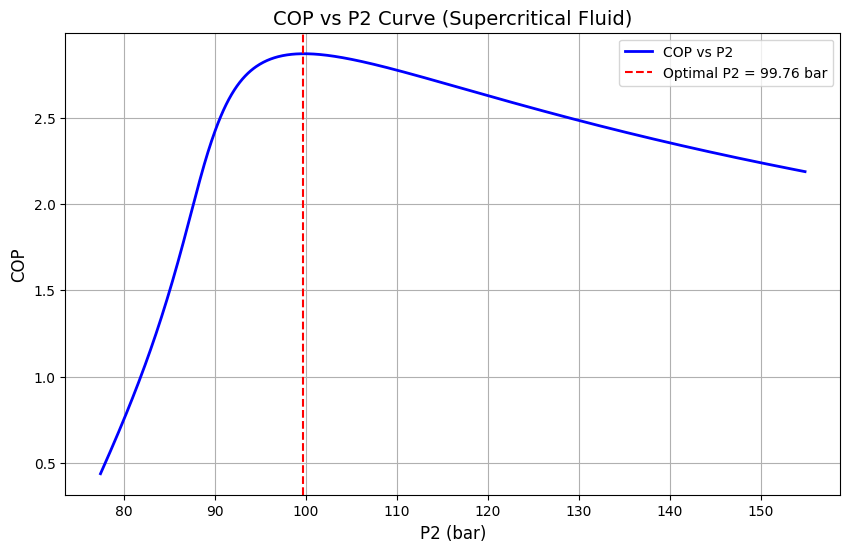

,State,h [J/kg],s [J/kg·K],T [K],P [Pa],Mass flow rate [kg/s],Q_f [W],W_c [W],Q_c [W],Q_q [W],COP,Volumetric Cooling Capacity [kJ/m³],Volumetric Compression Work [kJ/m³],Isentropic Efficiency of Compressor,Transcritical?,Fluid,Gas Cooler Avg. Temperature [K]
0,1,422884.000165,1784.683560,283.150000,4.502183e+06,1.096099,120000.0,41765.908146,4176.590815,157589.317331,2.873157,14796.816624,4635.01863,0.85,True,CO2,325.230763
1,2,457177.717902,1799.601578,346.038101,9.976163e+06,1.096099,120000.0,41765.908146,4176.590815,157589.317331,2.873157,14796.816624,4635.01863,0.85,True,CO2,325.230763
2,3,313404.860326,1357.537438,313.150000,9.976163e+06,1.096099,120000.0,41765.908146,4176.590815,157589.317331,2.873157,14796.816624,4635.01863,0.85,True,CO2,325.230763
3,4,313404.860326,1398.036412,283.150000,4.502183e+06,1.096099,120000.0,41765.908146,4176.590815,157589.317331,2.873157,14796.816624,4635.01863,0.85,True,CO2,325.230763




 * Exergy Destruction Data and Exergy Efficiency:



,Fluid,Exergy Loss Compressor [kW],Exergy Loss Condenser/Gas Cooler [kW],Exergy Loss Expansion Device [kW],Exergy Loss Evaporator [kW],Total Exergy Loss [kW],Relative Exergy Loss Compressor,Relative Exergy Loss Condenser/Gas Cooler,Relative Exergy Loss Expansion Device,Relative Exergy Loss Evaporator,Exergy Efficiency,Volumetric Cooling Capacity [MJ/m³],Volumetric Compression Work [MJ/m³],COP,Compressor Power [kW]
0,CO2,9.285519,10.699149,13.4571,12.56954,46.011308,0.20181,0.232533,0.292474,0.273184,0.1089,14.796817,4.635019,2.873157,41.765908


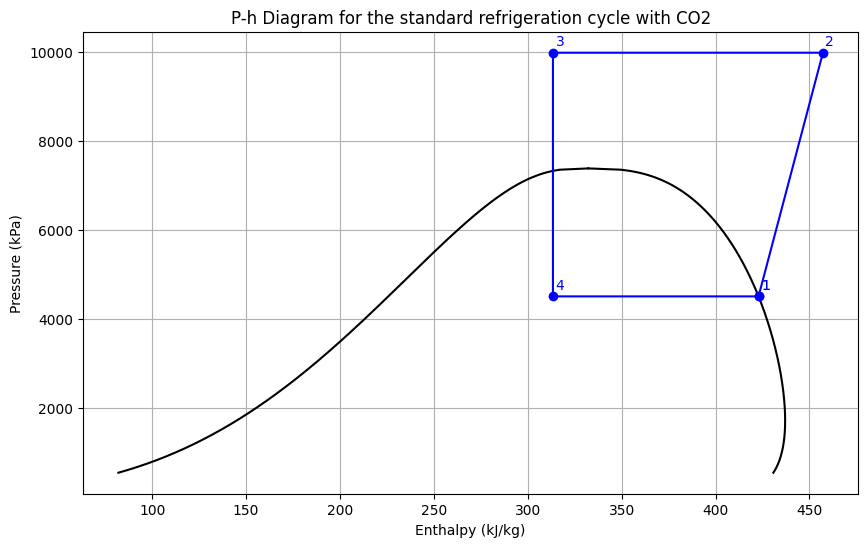

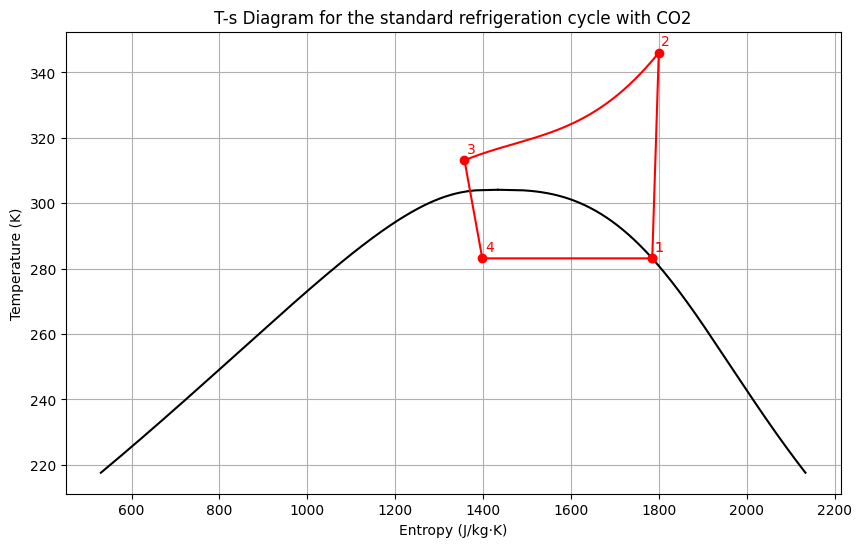

In [ ]:
list_dados, list_dict_exergia, df_list_dict_exergia = processar_ciclos_refrigeracao(T_evap, T_cond, T_L, T_H, n_is, Q_evap, r_Qc, fluido_1, fluid_list, T_sup, T_sub)

## Performance Analysis

*Note: In transcritical systems, comparisons with subcritical systems are based on the average entropic temperature of the gas cooler, which is assumed to be the condensing temperature for subcritical systems.



,Fluid,Exergy Loss Compressor [kW],Exergy Loss Condenser/Gas Cooler [kW],Exergy Loss Expansion Device [kW],Exergy Loss Evaporator [kW],Total Exergy Loss [kW],Relative Exergy Loss Compressor,Relative Exergy Loss Condenser/Gas Cooler,Relative Exergy Loss Expansion Device,Relative Exergy Loss Evaporator,Exergy Efficiency,Volumetric Cooling Capacity [MJ/m³],Volumetric Compression Work [MJ/m³],COP,Compressor Power [kW]
0,CO2,9.285519,10.699149,13.457100,12.569540,46.011308,0.201810,0.232533,0.292474,0.273184,0.108900,14.796817,4.635019,2.873157,41.765908
1,R134a,6.825936,10.096076,4.964736,12.569540,34.456288,0.198104,0.293011,0.144088,0.364797,0.150039,2.618251,0.595276,3.958546,30.314163
2,R11,5.973798,9.889902,2.306501,12.569540,30.739741,0.194335,0.321730,0.075033,0.408902,0.171100,0.541004,0.107860,4.514215,26.582696
3,R12,6.620316,10.057897,4.327740,12.569540,33.575493,0.197177,0.299561,0.128896,0.374367,0.154560,2.545054,0.561706,4.077843,29.427323
4,R22,6.664503,10.557473,4.378725,12.569540,34.170242,0.195038,0.308967,0.128144,0.367850,0.151812,4.103750,0.922113,4.005340,29.960003
5,R1234yf,7.367444,10.137330,6.599260,12.569540,36.673574,0.200892,0.276421,0.179946,0.342741,0.139659,2.345647,0.572934,3.684688,32.567209
6,R410A,7.548625,11.086310,6.927472,12.582585,38.144992,0.197893,0.290636,0.181609,0.329862,0.134058,5.617641,1.429453,3.536932,33.927712
7,R32,6.990080,11.575917,4.889204,12.569540,36.024742,0.194036,0.321332,0.135718,0.348914,0.143266,6.480239,1.542968,3.779867,31.747145
8,Ammonia,6.045268,11.559371,2.067778,12.569540,32.241957,0.187497,0.358520,0.064133,0.389850,0.163132,4.966443,1.038521,4.304004,27.881017
9,N2O,8.253660,9.266875,11.148587,12.569540,41.238662,0.200144,0.224713,0.270343,0.304800,0.122835,13.609996,3.779592,3.240826,37.027602


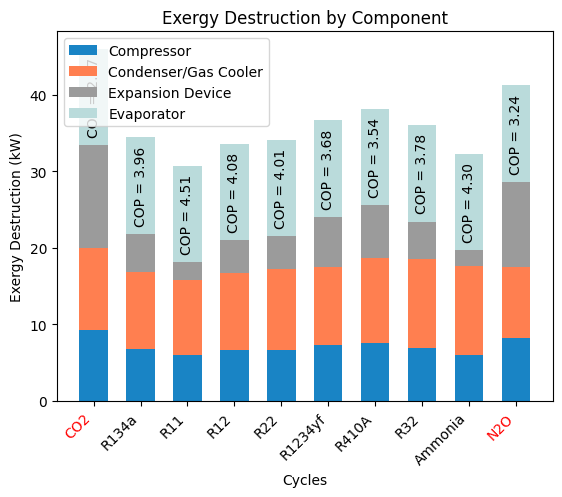

In [ ]:
if list_dados[0]['Transcritical?'] == True:
  print("*Note: In transcritical systems, comparisons with subcritical systems are based on the average entropic temperature of the gas cooler, which is assumed to be the condensing temperature for subcritical systems.\n")

display(df_list_dict_exergia)

Bd_comparativo(list_dict_exergia, list_dados)


## Environmental Effects

Error with R1234yf: Unable to use input parameter [GWP20] in Props1SI for fluid R1234yf; error was No outputs were able to be calculated : PropsSI("GWP20","",0,"",0,"R1234yf") :: inputs were :"GWP20","R1234yf"
Error with R410A: Unable to use input parameter [GWP20] in Props1SI for fluid R410A; error was No outputs were able to be calculated : PropsSI("GWP20","",0,"",0,"R410A") :: inputs were :"GWP20","R410A"
Error with Ammonia: Unable to use input parameter [GWP20] in Props1SI for fluid Ammonia; error was No outputs were able to be calculated : PropsSI("GWP20","",0,"",0,"Ammonia") :: inputs were :"GWP20","Ammonia"


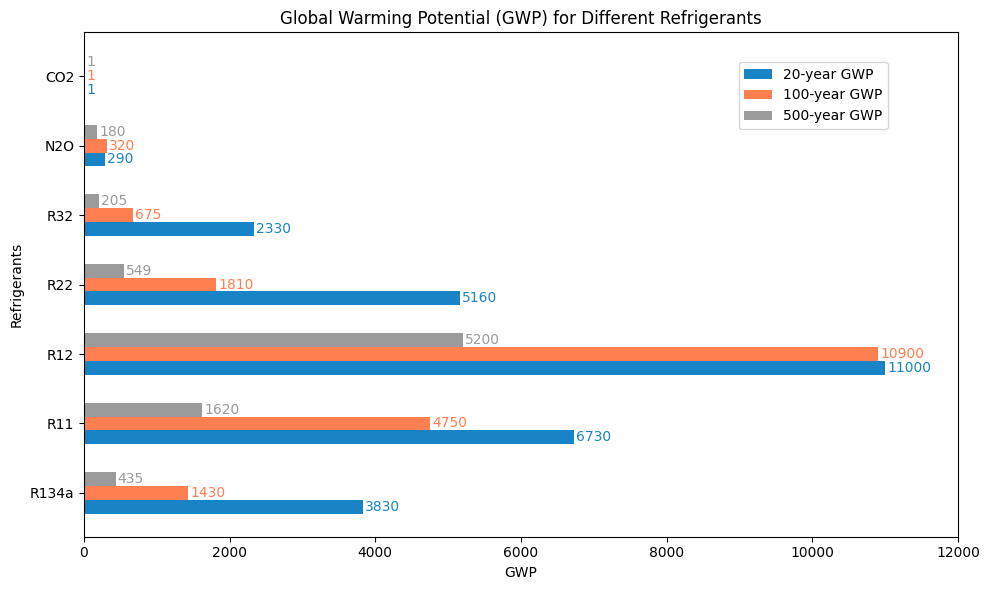

In [ ]:
environmental_effects(fluido_1, fluid_list)

# REFERENCES

CoolProp: http://www.coolprop.org/coolprop/HighLevelAPI.html#parameter-table

MORAN, M.J.; SHAPIRO, H.N.; BOETTNER, D.D.; BAILEY, M.B. Fundamentals of Engineering Thermodynamics. 8. ed. Hoboken: Wiley, 2014. ISBN 9781118832301.

STEWART, Susan W.; SHELTON, Sam V. The usefulness of entropic average temperatures. In: Proceedings of the ASME International Mechanical Engineering Congress and Exposition. Anaheim, California, 2004. p. 1-6. DOI: 10.1115/IMECE2004-60235.

SEYAM, Shaimaa. Energy and Exergy Analysis of Refrigeration Systems. 2019. ISBN 978-1-83880-666-8. DOI 10.5772/intechopen.88862.

TAO, Y.B.; HE, Y.L.; TAO, W.Q. Exergetic analysis of transcritical CO2 residential air-conditioning system based on experimental data. State Key Laboratory of Multiphase Flow in Power Engineering, School of Energy & Power Engineering, Xi’an Jiaotong University, Xi’an, Shaanxi 710049, China, 2009.

PATIL, Omprakash S.; SHET, Shrikant A.; JADHAO, Manish; AGRAWAL, Neeraj. Energetic and exergetic studies of modified CO2 transcritical refrigeration cycles. Departamento de Engenharia Mecânica, Dr. B. A. Technological University Lonere, Raigad, Maharashtra 402103, Índia, 2020.

In [ ]:
print_equations()


Exergy Rate:



<IPython.core.display.Math object>


Exergy Destruction Rate [kW] - Compressor (1-2):



<IPython.core.display.Math object>


Exergy Destruction Rate [kW] - Gas Cooler / Condenser (2-3):



<IPython.core.display.Math object>


Exergy Destruction Rate [kW] - Expansion Device (3-4):



<IPython.core.display.Math object>


Exergy Destruction Rate [kW] - Evaporator (4-1):



<IPython.core.display.Math object>


Total Exergy Destruction Rate [kW]:



<IPython.core.display.Math object>


--

Relative Exergy Destruction Rate:



<IPython.core.display.Math object>


--

Exergy Efficiency:



<IPython.core.display.Math object>


--

Entropic Average Temperature:



<IPython.core.display.Math object>